In [ ]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json
import pandas as pd

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize

!wget https://raw.githubusercontent.com/AakashSudhakar/2018-data-science-bowl/master/compressed_files/stage1_test.zip -c
!wget https://raw.githubusercontent.com/AakashSudhakar/2018-data-science-bowl/master/compressed_files/stage1_train.zip -c

!mkdir stage1_train stage1_test

!unzip stage1_train.zip -d stage1_train/
!unzip stage1_test.zip -d stage1_test/

TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]


from config import Config
import utils
import model as modellib
import visualize
from model import log

%matplotlib inline 

ROOT_DIR = os.getcwd()

MODEL_DIR = os.path.join(ROOT_DIR, "logs")


COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [ ]:
class ShapesConfig(Config):

    
    NAME = "shapes"

    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    NUM_CLASSES = 1 + 1  


    IMAGE_MIN_DIM = 896
    IMAGE_MAX_DIM = 896

    RPN_ANCHOR_SCALES = (8, 16, 64, 128, 256)  

    TRAIN_ROIS_PER_IMAGE = 800

    STEPS_PER_EPOCH = 200

    VALIDATION_STEPS = 50
    
config = ShapesConfig()
config.display()

In [ ]:
def get_ax(rows=1, cols=1, size=8):

    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [ ]:
class ShapesDataset(utils.Dataset):
    
    def load_shapes(self, mode):
        
       
        self.add_class("shapes", 1, "nucleus")
        

        if mode == "train":  
            for n, id_ in enumerate(train_ids):
                if n < int(len(train_ids) * 0.9):
                    path = TRAIN_PATH + id_
                    img_path = path + '/images/'
                    self.add_image("shapes", image_id=id_, path=img_path)
              
        if mode == "val":   
            for n, id_ in enumerate(train_ids):
                if n >= int(len(train_ids) * 0.9):
                    path = TRAIN_PATH + id_
                    img_path = path + '/images/'
                    self.add_image("shapes", image_id=id_, path=img_path)      

    def load_image(self, image_id):
        
        info = self.image_info[image_id]
        info = info.get("id")
       
        path = TRAIN_PATH + info
        img = imread(path + '/images/' + info + '.png')[:,:,:3]
        img = resize(img, (config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1]), mode='constant', preserve_range=True)
       
        return img

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        
        info = self.image_info[image_id]
        info = info.get("id")
        path = TRAIN_PATH + info
        number_of_masks = len(next(os.walk(path + '/masks/'))[2])
        mask = np.zeros([config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], number_of_masks], dtype=np.uint8)
        iterator = 0
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            mask_ = imread(path + '/masks/' + mask_file)
            mask_ = resize(mask_, (config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1]), mode='constant', preserve_range=True)
            mask[:, :, iterator] = mask_
            iterator += 1
       
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(number_of_masks-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
            
       
        class_ids = np.ones((number_of_masks,), dtype=int)
        
        return mask, class_ids.astype(np.int32)
         
       
        

In [ ]:

dataset_train = ShapesDataset()
dataset_train.load_shapes("train")
dataset_train.prepare()

dataset_val = ShapesDataset()
dataset_val.load_shapes("val")
dataset_val.prepare()

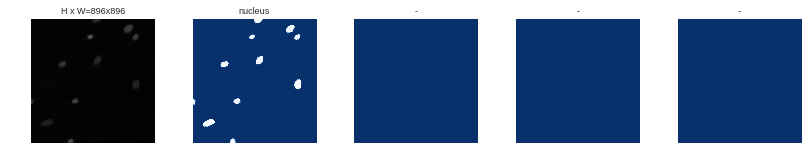

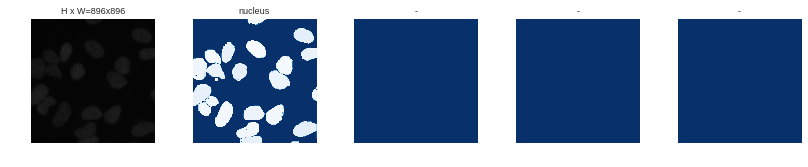

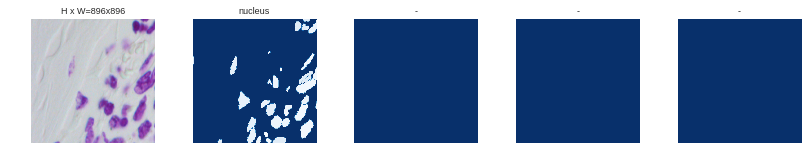

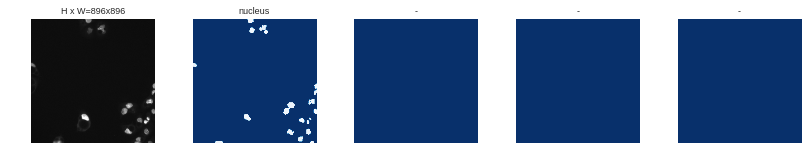

In [ ]:

image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [ ]:

model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [ ]:
init_with = "coco"  

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":

    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    
    model.load_weights(model.find_last()[1], by_name=True)

In [ ]:
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')

In [ ]:

model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes3.h5")
model.keras_model.save_weights(model_path)

In [ ]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()


model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

model_path = model.find_last()[1]

assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

original_image           shape: (896, 896, 3)         min:    0.90816  max:  229.82143
image_meta               shape: (10,)                 min:    0.00000  max:  896.00000
gt_class_id              shape: (12,)                 min:    1.00000  max:    1.00000
gt_bbox                  shape: (12, 4)               min:    4.00000  max:  896.00000
gt_mask                  shape: (896, 896, 12)        min:    0.00000  max:  255.00000


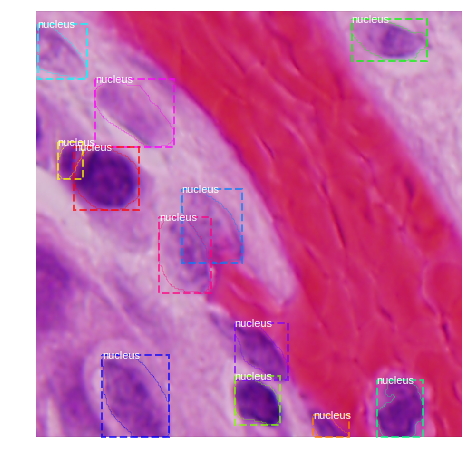

In [ ]:

image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))